### Test on a crioconite sample
The SSE background reduction allows for detecting peaks covered by Compton events of radioactive sources with higher activities. In this notebook we test the A/E method and the autoencoder+classifier method for unveiling the presence of a peak at ~480 keV (due to a crioconite sample) otherwise covered by the Compton Edge of the 137 - Cs

In [1]:
from begepro.autoencoder.sn_analysis import Comparison, compute_threshold
from begepro.autoencoder.dataloading import DataLoader, Dataset
from begepro.autoencoder.autoencoder_classifier import Autoencoder, Classifier

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2023-02-27 23:47:13.377010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 23:47:13.782944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 23:47:13.782961: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 23:47:14.868950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Data and models loading

In [2]:
opts = {"loadpath": "/mnt/e/BEGE_data/waveforms_crioconite", # where .bin files are stored
"savepath": "../../dataset/crioconite", # where .npy files will be saved with readfiles() and loaded with load()
"subsampling_factor": 3}
dataloader = DataLoader(opts)

waveforms, currents, energies, amplitudes, pulse_height = dataloader.load()

autoencoder_class = Autoencoder()
classifier_class = Classifier(input_size = 5)
autoencoder_class.load_model("../../models/autoencoder", "../../models/encoder")
classifier_class.load_model("../../models/classifier")

2023-02-27 23:47:35.398865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-27 23:47:35.398920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DARTWARS0): /proc/driver/nvidia/version does not exist
2023-02-27 23:47:35.399866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Scaling factors for the encoded datapoints (necessary step before passing to the classifier)
mus = np.array([4.778311 , 4.25894  , 3.7369454, 4.971836 , 3.8563824])
stds = np.array([1.23048101e-03, 6.46553329e-04, 6.02247721e-01, 6.72660279e-01,
        4.74731220e-05])
predictions, _, _ = autoencoder_class.encode(waveforms, mus, stds)

46875/46875 [==============================] - 39s 830us/step


Getting the NN prediction scores 

In [6]:
scores = classifier_class.classifier.predict(predictions)[:,0]

46875/46875 [==============================] - 37s 781us/step


Computing A/E ratios

In [4]:
avse = amplitudes/pulse_height

Example: selecting events with scores > 0.3

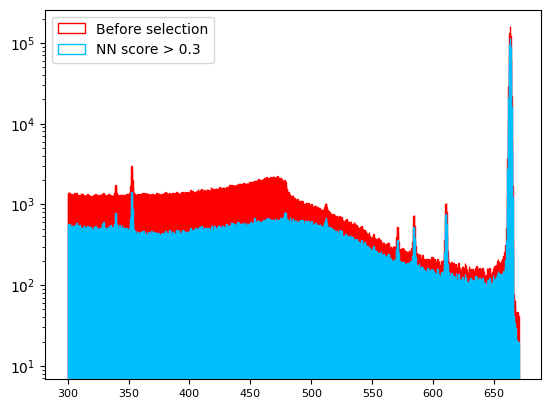

In [96]:
predictions_nn = scores > 0.3
avse_threshold = compute_threshold(avse, predictions_nn.sum(), "avse", stress_limit = 100000)
nbins = 904
plt.hist(energies, range = [300, 670], bins = nbins, ec = "red", facecolor="white")[-1]
plt.hist(energies[predictions_nn], range = [300, 670], bins = nbins, ec = "deepskyblue", facecolor="white")[-1]
# plt.hist(energies, range = [468, 488], bins = nbins, ec = "red", facecolor="white")[-1]
# plt.hist(energies[predictions_nn], range = [468, 488], bins = nbins, ec = "deepskyblue", facecolor="white")[-1]
                                            
plt.legend(["Before selection", "NN score > 0.3"])
plt.yscale("log")
# plt.savefig("criopeak_NN.svg")

Selecting the same number of events in the overall spectrum with the A/E method (i.e. A/E < 0.01828)

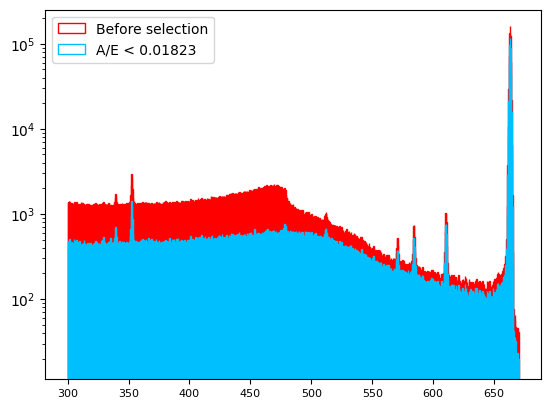

In [94]:
nbins = 904

plt.hist(energies, range = [300, 670], bins = nbins, ec = "red", facecolor="white")[-1]
plt.hist(energies[avse < avse_threshold], range = [300, 670], bins = nbins, ec = "deepskyblue", facecolor="white")[-1]
plt.legend(["Before selection", "A/E < 0.01823"])
plt.yscale("log")
# plt.savefig("criopeak_avse.svg")

Getting the S/B ratio at different selection strengths

In [97]:
comparison = Comparison(energies, avse, scores)
M_ELECTRON = 511
cs = np.linspace(0.0, 0.695, 100)
peaks = [478]
sb_nn, std_sb_nn, sb_avse, std_sb_avse, avse_thresholds = comparison.compare([478], cs, benchmark = "nn", width = 20, nbins = 97)

Estimating S/B for peak at 478 keV


### Results
Without enough selection (score threshold $\lesssim 0.2$) The fit fails in detecting the peak. Overall, the A/E method seems to perform better, despite the large error bars.

In [98]:
plt.rc('xtick', labelsize=8) 

for n in range(len(peaks)):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    ax1.plot(cs, sb_nn[:,n], color =  'deepskyblue')
    ax1.fill_between(cs, sb_nn[:,n] + std_sb_nn[:,n], sb_nn[:,n] - std_sb_nn[:,n],label='_nolegend_', alpha = 0.5, color = 'skyblue')
    ax1.plot(cs, sb_avse[:,n], color = 'red')
    ax1.fill_between(cs, sb_avse[:,n] + std_sb_avse[:,n], sb_avse[:,n] - std_sb_avse[:,n], color = 'coral', label='_nolegend_', alpha = 0.5)

    d = 10
    new_tick_locations = np.array(cs[::d])

    ax1.set_xticks(cs[::d])

    ax1.set_xticklabels(["> "+str(round(float(c), 2)) for c in cs[::d]])

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(cs[::d])
    ax2.set_xticklabels(["< "+str(round(float(avse_threshold*100), 2)) for avse_threshold in avse_thresholds[::d,n]])

    ax1.set_xlabel("NN score threshold")
    ax2.set_xlabel("A/E score threshold [x 100]")
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("axes", -0.15))

    ax1.set_ylabel("S/B ratio")
    plt.title(f"Peak at {peaks[n]} keV")
    ax1.legend(["NN", "A/E"])
    plt.savefig(f"../../results/z_peak_at_{peaks[n]}_122_sampling_.svg", bbox_inches='tight')
    plt.clf()

<Figure size 640x480 with 0 Axes>